In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import time

from scipy import stats

import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, RFE


# for classification
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# for regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Preprocessing of the data

In [2]:
# load and import the data

df_final = pd.read_csv('df_model.csv')

In [3]:
df_model = df_final.copy()

In [4]:
df_model.shape

(107765, 55)

In [5]:
def drop_columns(df):
    '''
    Drop columns from the dataframe

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to drop columns from

        
    Returns
    -------
    df : pandas dataframe
        The dataframe with the columns dropped
    '''

    cols_to_drop = ['RFM_BUYER', 'ORDER_VALUE_RANGE','ID_CONDITION','ID_CATEGORY',
                   'ID_SUBCATEGORY','ID_BRAND', 'ID_PAYMENT_TYPE', 'ORDER_MARKETING_CHANNEL' , 
                   'Total_likes', 'Total_wishes', 'Total_MMAO_NB', 'Avg_commision_x' , 'Avg_commision_y', 
                   'NL_REACTIVITY_GROUP','NB_PURCHASED', 'RANK_BUYER', 'BUYER_SEGMENT', 'NB_SOLD','RANK_WITHIN_SEGMENT', 
                   'ID_SEGMENT', 'ID_RFM_BUYER','Frequnecy_like_12M']
    
    #
    #'NB_products_liked'

    to_drop_maybe = ['NB_products_liked','NB_categories_liked', 'NB_products_commented', 'NB_categories_commented']

    df.drop(cols_to_drop, axis=1, inplace=True)

    return df

In [6]:
def date_time_converting(df):
    '''
    Convert the date columns to datetime and create new columns for the number of days 
    between the first order and the creation of the account

    Parameters
    ----------

    df : pandas dataframe
    The dataframe to convert the date columns to datetime and create new columns for the 
    number of days between the first order and the creation of the account

    Returns
    -------
    df : pandas dataframe
    The dataframe with the date columns converted to datetime and new columns for the

    '''
    # Convert the date columns to datetime
    df['DATE_CREATION'] = pd.to_datetime(df['DATE_CREATION'])
    df['DATE_FIRST_PURCHASE'] = pd.to_datetime(df['DATE_FIRST_PURCHASE'])
    df['DATE_LAST_LOGIN'] = pd.to_datetime(df['DATE_LAST_LOGIN'])
    df['DATE_LAST_PURCHASE'] = pd.to_datetime(df['DATE_LAST_PURCHASE'])

    # Create a new column for the number of days between the first order and the creation of the account
    df['days_bf_first_order'] = (df['DATE_FIRST_PURCHASE'] - df['DATE_CREATION']).dt.days

    # recency login compared to today
    df['days_since_last_login'] = (pd.to_datetime('2023/02/11') - df['DATE_LAST_LOGIN']).dt.days

    # recency order compared to today
    df['days_since_last_order'] = (pd.to_datetime('2023/02/11') - df['DATE_LAST_PURCHASE']).dt.days

    # Drop the date columns
    df.drop(['DATE_CREATION', 'DATE_NEW_BUYER', 'LastLikeDate', 'LastCommentDate', 
             'DATE_FIRST_PURCHASE', 'DATE_LAST_LOGIN', 'DATE_LAST_PURCHASE'], axis=1, inplace=True)
    df.drop(['Total_nb_likes', 'Total_nb_wish'], axis=1, inplace=True)

    return df

In [7]:
def missing_values(df):
    # Dealing with the missing values

    # Replacing the missing values with 0 
    df['NB_products_liked'].fillna(0, inplace=True)
    df['NB_categories_liked'].fillna(0, inplace=True)
    #df['Frequnecy_like_12M'].fillna(0, inplace=True)
    df['NB_products_commented'].fillna(0, inplace=True)
    df['NB_categories_commented'].fillna(0, inplace=True)
    df['Frequnecy_comment_12M'].fillna(0, inplace=True)

    # Replacing the missing values with 999
    df['Recency_comment'].fillna(999, inplace=True)
    df['Recency_liked'].fillna(999, inplace=True)

    return df

In [8]:
def encoding(df):
    ### ecoding the categorical variables 

    ##ordinal encoding
    # USER_SEGMENT
    user_seg_map = {'Hibernating' :0, 'Inactive 6-12M': 1, 'Dormant 6M': 2, 'About to Sleep': 3, 'At High Risk':4, 'At Risk' :5, 'Need Attention':6, 'New Customer': 7, 'Potential Engaged':8, 'Engaged':9, 'Highly Engaged':10}
    df['USER_SEGMENT'] = df['USER_SEGMENT'].map(user_seg_map)

    # #BUYER_SEGMENT 
    # buyer_seg_map = {'Low potential one timers':0,'High potential one timers' : 1,'Low quality repeaters':2, 'High potential repeaters':3, 'Top buyers - only':4, 'Top buyers - low value': 5, 'Top buyers - high value':6, 'Top buyers - VVIC':7}
    # # OR maybe map with levels 1 to 3 with one timers, repeaters and top buyers
    # df['BUYER_SEGMENT'] = df['BUYER_SEGMENT'].map(buyer_seg_map)
    #drop the columns 

    return df

In [9]:
df = drop_columns(df_model)
df = date_time_converting(df_model)
df = missing_values(df_model)
df = encoding(df_model)

# set ID_BUYER as index

df.set_index('ID_BUYER', inplace=True)

In [10]:
# print the number of inactive 0 and repeaters 0 or 1

df.head()

,ID_GENDER,INACTIVE,NB_PUBLISHED,USER_SEGMENT,REPEATER,CLTV,NB_OFFERS,AVG_OFFERS,NB_DAYS_ONLINE,DEPOSIT_PRICE,PRICE_SOLD_GMV,NB_ITEMS,DISCOUNT_AMOUNT_GMV,BUYER_FEE_GMV,MMAO_PRICE_DROP,VOUCHER_REVENUE,NB_products_liked,NB_categories_liked,Recency_liked,NB_products_commented,NB_categories_commented,Recency_comment,Frequnecy_comment_12M,days_bf_first_order,days_since_last_login,days_since_last_order
ID_BUYER,,,,,,,,,,,,,,,,,,,,,,,,,,
15347487,2,0,1,10,1.0,4011.086544,55.0,1.447368,61,505.853754,443.753592,1.0,12.464280,9.906643,18.370339,12.464280,185.0,5.0,9.0,2.0,1.0,204.0,406.0,163,33,149
17180639,2,0,1,4,0.0,684.884065,20.0,2.222222,198,247.010703,170.155022,3.0,7.751938,17.441860,39.033872,7.751938,44.0,5.0,68.0,0.0,0.0,999.0,0.0,20,63,217
13154196,1,0,0,5,0.0,239.520964,136.0,1.700000,469,173.410970,79.840321,3.0,7.984032,0.000000,15.037268,7.984032,29.0,2.0,319.0,0.0,0.0,999.0,0.0,216,163,372
16618931,1,0,0,1,0.0,273.159145,0.0,0.000000,77,271.867612,273.159145,1.0,23.752969,0.000000,0.000000,23.752969,0.0,0.0,999.0,0.0,0.0,999.0,0.0,1,291,290
15612679,2,0,0,2,0.0,209.625000,0.0,0.000000,2,195.000000,209.625000,1.0,0.000000,17.730496,0.000000,0.000000,1.0,1.0,340.0,0.0,0.0,999.0,0.0,1,160,367


In [10]:
def outliers_removal(df, outlier_method:str=None):
    '''
    Remove the outliers from the dataframe

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to remove the outliers from

    outlier_method : str
        The method to use to remove the outliers

    Returns
    -------
    df : pandas dataframe
        The dataframe with the outliers removed
    '''

    if outlier_method == 'IQR':
        # IQR method
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

    elif outlier_method == 'zscore':
        # Z-score method
        df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

    return df

In [9]:
df.shape

(107765, 26)

In [14]:
df = outliers_removal(df, outlier_method='zscore')

In [15]:
df.shape

(88298, 31)

In [15]:
def select_features(X_train, y_train, X_test, method:str=None, VT_threshold=0.1, KBest_k=10):

    colname = X_train.columns

    X_train = X_train.copy()
    X_test = X_test.copy()
    y_train = y_train.copy()

    if method == 'variance':
        # create an instance of VarianceThreshold with a threshold of 0.1
        selector = VarianceThreshold(threshold=VT_threshold)

        # fit the selector to the training data
        selector.fit(X_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = selector.get_support() 


        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    elif method == 'univariate':
        # create an instance of SelectKBest with the desired parameters
        selector = SelectKBest(f_regression, k=10)

        # fit the selector to the training data
        selector.fit(X_train, y_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = colname[selector.get_support()]

        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    elif method == 'recursive':
        # create an instance of SelectKBest with the desired parameters
        selector = RFE(estimator=LinearRegression(), n_features_to_select=10)

        # fit the selector to the training data
        selector.fit(X_train, y_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = colname[selector.get_support()]

        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    else:
        print('Invalid method')

In [10]:
def corr_plot(df):
    '''
    Plot correlation matrix

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to plot

    Returns
    -------
    plot of correlation matrix
    
    '''

    corr = df.corr()
    f, ax = plt.subplots(figsize=(20, 9))
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask= np.triu(corr, k=1))
    plt.show()

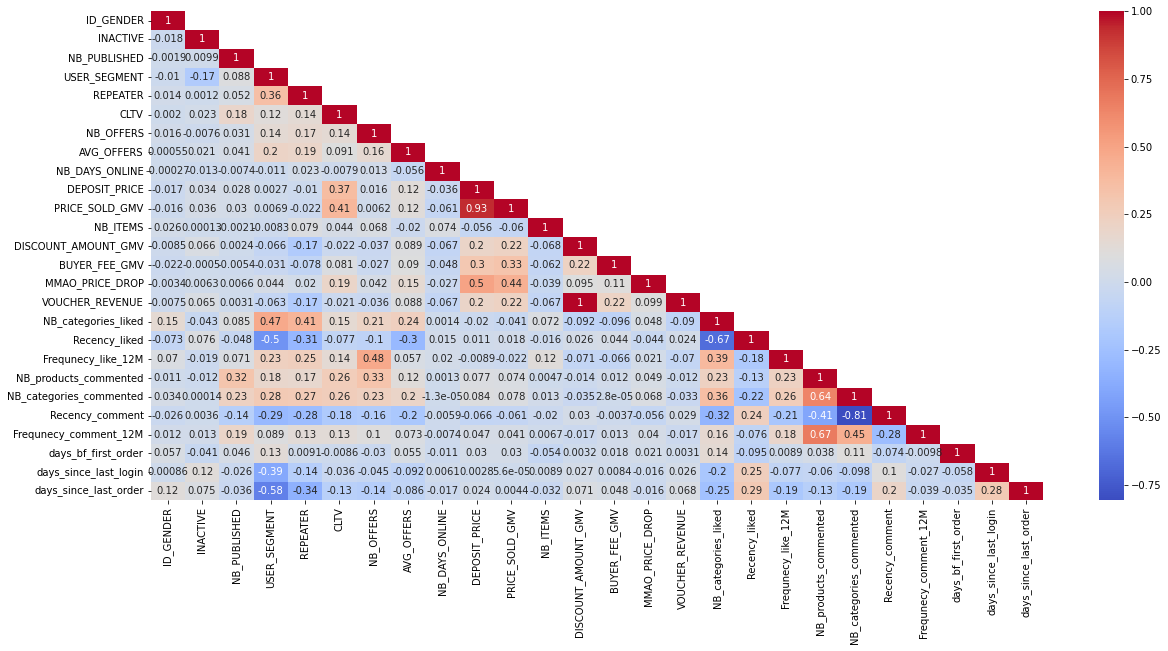

In [11]:
corr_plot(df)

In [11]:
# keep only 10000 rows for the moment 
df = df.sample(n=10000, random_state=42)

df.shape

(10000, 26)

In [12]:
# Preparing the data to be used in the model
# Split the data into X and y 
X = df.drop(['REPEATER', 'CLTV'], axis=1)
y_rep = df['REPEATER']
y_cltv = df['CLTV']

In [13]:
# keeping colnames for later use

colnames = X.columns

In [14]:
# print the shape of X and y

print(X.shape)
print(y_rep.shape)
print(y_cltv.shape)

(10000, 24)
(10000,)
(10000,)


In [13]:
def pre_processing(df, X_train, X_test, scaling:bool = False, scaler:str = None, outliers:bool = False, outliers_method:str = None):
    '''
    Preprocess the data to be used in the model

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to preprocess

    X_train : pandas dataframe
        The train set

    X_test : pandas dataframe
        The test set

    Returns
    -------
    X_train : pandas dataframe
        The train set after preprocessing

    X_test : pandas dataframe
        The test set after preprocessing

    '''

    # Scaling the data
    if scaling:
        if scaler == 'MinMaxScaler':
            # MinMaxScaler
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        elif scaler == 'StandardScaler':
            # StandardScaler
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        else:
            print('Please choose a valid scaler')   
    
    return X_train, X_test

# Model 1 : Predicting the probability of a customer to be a Repeater

In [15]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_rep, test_size=0.2, random_state=42)

In [16]:
X_train, X_test = pre_processing(df, X_train, X_test, scaling=True, scaler='StandardScaler')

NameError: name 'pre_processing' is not defined

Testing different classification models

In [17]:
def classification_model_testing(df, X_train, X_test, y_train, y_test):
    '''

    Function that testes all the classification model imported into the notebook to have a global idea of the best model to use
    It should output a pandas dataframe called df_classification_result where each row represents the result of one model
    The columns should be the name of the model, the accuracy score, the precision score, the recall score and the f1 score

    Parameters
    ----------
    df : pandas dataframe
    The dataframe to use to train the model

    '''
    #set a seed for reproducibility
    np.random.seed(42)

    # Import the models

    models = {'Logistic Regression': LogisticRegression(), 'KNN': KNeighborsClassifier(), #'SVM': SVC(), 
              'Decision Tree': DecisionTreeClassifier(), 'Random Forest': RandomForestClassifier( n_jobs=-1),
              'Gradient Boosting': GradientBoostingClassifier(), 'XGBoost': XGBClassifier(verbosity=0, n_jobs=-1, tree_method='gpu_hist', gpu_id=0, random_state=42, objective='binary:logistic'),
                'LightGBM': LGBMClassifier(boosting_type='gbdt', objective='binary', n_jobs=-1, random_state=42),
                'CatBoost': CatBoostClassifier(verbose=0, random_state=42, task_type='GPU')}
    
    df_classification_result = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        df_classification_result = df_classification_result.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}, ignore_index=True)
        end = time.time()
        print(f'{name} has been fitted and evaluated')
        print(f'It took {end-start} seconds to fit and evaluate the model')
        print('--------------------------------------')

    df_classification_result = df_classification_result.sort_values(by='F1', ascending=False)

    return df_classification_result      

In [16]:
df_classification_result = classification_model_testing(df, X_train, X_test, y_train, y_test)

Logistic Regression has been fitted and evaluated
It took 0.5276405811309814 seconds to fit and evaluate the model
--------------------------------------
KNN has been fitted and evaluated
It took 2.440467596054077 seconds to fit and evaluate the model
--------------------------------------
SVM has been fitted and evaluated
It took 481.76195549964905 seconds to fit and evaluate the model
--------------------------------------
Decision Tree has been fitted and evaluated
It took 1.4491217136383057 seconds to fit and evaluate the model
--------------------------------------
Random Forest has been fitted and evaluated
It took 3.8247687816619873 seconds to fit and evaluate the model
--------------------------------------
Gradient Boosting has been fitted and evaluated
It took 26.784815073013306 seconds to fit and evaluate the model
--------------------------------------
XGBoost has been fitted and evaluated
It took 0.9766240119934082 seconds to fit and evaluate the model
--------------------

In [19]:
df_classification_result # with the subset of 10k rows

,Model,Accuracy,Precision,Recall,F1
8,CatBoost,0.8115,0.791538,0.814225,0.802721
7,LightGBM,0.8075,0.785056,0.814225,0.799375
5,Gradient Boosting,0.7995,0.788687,0.784501,0.786589
6,XGBoost,0.7865,0.766839,0.785563,0.776088
4,Random Forest,0.7775,0.780791,0.733546,0.756431
0,Logistic Regression,0.7475,0.762305,0.674098,0.715493
3,Decision Tree,0.7210,0.697125,0.720807,0.708768
2,SVM,0.7440,0.785146,0.628450,0.698113
1,KNN,0.7145,0.701850,0.684713,0.693176


In [17]:
df_classification_result # with whole dataset

,Model,Accuracy,Precision,Recall,F1
7,LightGBM,0.815339,0.783225,0.835554,0.808543
8,CatBoost,0.815849,0.786703,0.830583,0.808048
6,XGBoost,0.807962,0.774613,0.829986,0.801344
5,Gradient Boosting,0.804946,0.787751,0.796679,0.792190
1,KNN,0.728715,0.701464,0.728873,0.714906
2,SVM,0.751404,0.782452,0.647246,0.708456
3,Decision Tree,0.721895,0.699294,0.708888,0.704058
0,Logistic Regression,0.742634,0.761265,0.653410,0.703226
4,Random Forest,0.719297,0.702179,0.691986,0.697046


Choice of best models, and hyperparameter tuning

In [21]:
# function for hyper parameter tuning LightGBM 
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def hyperparameter_tuning_lgbm(X_train, X_test, y_train, y_test):
    '''
    Function that performs hyperparameter tuning on LightGBM model

    Parameters
    ----------
    X_train : pandas dataframe
        The train set

    X_test : pandas dataframe
        The test set

    y_train : pandas dataframe
        The train set

    y_test : pandas dataframe
        The test set

    Returns
    -------
    best_model : LightGBM model
        The best model after hyperparameter tuning

    '''

    #set a seed for reproducibility
    np.random.seed(42)

    # Create the parameter grid
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 1000),
        'num_leaves': Integer(10, 100),
        'max_depth': Integer(3, 10),
        'min_child_samples': Integer(10, 100),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(0.0, 0.5),
        'reg_lambda': Real(0.0, 0.5)
    }
        
    # Create the model to use for hyperparameter tuning
    model = LGBMClassifier(boosting_type='gbdt', objective='binary', n_jobs=-1, random_state=42)

    start = time.time()

    # Setup RandomizedSearchCV
    bayes_cv_tuner = BayesSearchCV(
        model,
        param_space,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    
    # Fit the RandomizedSearchCV version of model

    bayes_cv_tuner.fit(X_train, y_train)

    # Find the best model hyperparameters
    bayes_cv_tuner.best_params_

    end = time.time()

    print(f'It took {end-start} seconds or {(end-start) / 60} minutes to fit and evaluate the model')

    print('--------------------------------------')
    #print best score and params

    print('Best score: ', bayes_cv_tuner.best_score_)
    print('Best params: ', bayes_cv_tuner.best_params_)

    print('--------------------------------------')

    # Evaluate the RandomizedSearchCV model

    y_pred = bayes_cv_tuner.predict(X_test)

    # Evaluate the model

    accuracy = accuracy_score(y_test, y_pred)

    print(f'Accuracy score: {accuracy}')

    precision = precision_score(y_test, y_pred)

    print(f'Precision score: {precision}')

    recall = recall_score(y_test, y_pred)

    print(f'Recall score: {recall}')

    f1 = f1_score(y_test, y_pred)

    print(f'F1 score: {f1}')
    print('--------------------------------------')

    # put results in a dataframe

    df_classification_result = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

    df_classification_result = df_classification_result.append({'Model': 'LightGBM_tuned', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}, ignore_index=True)

    # Create a confusion matrix

    print('Confusion matrix: ', confusion_matrix(y_test, y_pred))

    # Create a classification report

    print('Classification report: \n', classification_report(y_test, y_pred))

    # Create a dataframe with the feature importance

    feature_importance = pd.DataFrame({'Feature': colnames, 'Importance': bayes_cv_tuner.best_estimator_.feature_importances_})

    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Plot the feature importance

    plt.figure(figsize=(10, 10))

    sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])

    plt.title('Feature Importance')

    plt.show()

    return bayes_cv_tuner.best_estimator_, df_classification_result

It took 322.04573106765747 seconds or 5.367428851127625 minutes to fit and evaluate the model
--------------------------------------
Best score:  0.8067499999999999
Best params:  OrderedDict([('colsample_bytree', 0.6615350227811718), ('learning_rate', 0.013698631758228757), ('max_depth', 5), ('min_child_samples', 22), ('n_estimators', 718), ('num_leaves', 18), ('reg_alpha', 0.4787620082630714), ('reg_lambda', 0.025808936905255382), ('subsample', 0.9793619720845743)])
--------------------------------------
Accuracy score:  0.8015
Precision score:  0.7853403141361257
Recall score:  0.7961783439490446
F1 score:  0.790722192936215
Confusion matrix:  [[853 205]
 [192 750]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.82      0.81      0.81      1058
         1.0       0.79      0.80      0.79       942

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80   

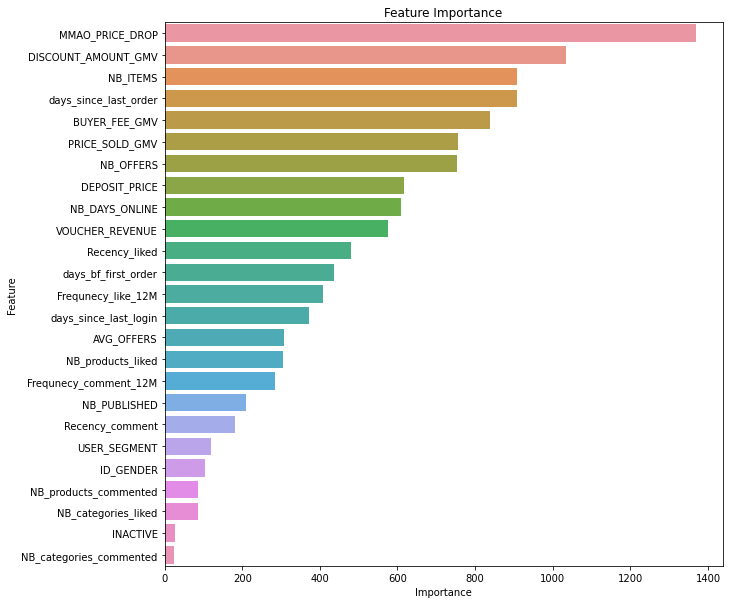

In [22]:
best_model_LGBM_class, df_classification_result = hyperparameter_tuning_lgbm(X_train, X_test, y_train, y_test)

# Model 2 : Predicting the Customer Lifetime Value (CLV) of a customer 

In [18]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_cltv, test_size=0.2, random_state=42)

In [30]:
X_train, X_test = pre_processing(df, X_train, X_test, scaling=True, scaler='StandardScaler')

In [19]:
def regression_model_testing(df, X_train, X_test, y_train, y_test):
    '''

    Function that testes all the regression model imported into the notebook to have a global idea of the best model to use
    It should output a pandas dataframe called df_regression_result where each row represents the result of one model
    The columns should be the name of the model, the mean absolute error, the mean squared error and the root mean squared error

    Parameters
    ----------
    df : pandas dataframe
    The dataframe to use to train the model

    '''
    #set a seed for reproducibility
    np.random.seed(42)

    # Import the models

    models = {'Linear Regression': LinearRegression(), 'Ridge Regression': Ridge(), 'Lasso Regression': Lasso(),
                'ElasticNet Regression': ElasticNet(), 'Decision Tree': DecisionTreeRegressor(), 'Random Forest': RandomForestRegressor( n_jobs=-1),
                'Gradient Boosting': GradientBoostingRegressor(), 'CatBoost': CatBoostRegressor(verbose=0), 
                'XGBoost': XGBRegressor(n_jobs=-1, random_state=42, verbosity=0, objective='reg:squarederror', booster='gbtree', tree_method='gpu_hist'),
                'LightGBM': LGBMRegressor(n_jobs=-1, random_state=42, boosting_type='gbdt', objective='regression')}
    
    df_regression_result = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        df_regression_result = df_regression_result.append({'Model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
        end = time.time()
        print(f'{name} has been fitted and evaluated')
        print(f'It took {end-start} seconds to fit and evaluate the model')
        print('--------------------------------------')

    
    df_regression_result = df_regression_result.sort_values(by='R2', ascending=False)

    return df_regression_result
        

In [20]:
df_regression_result = regression_model_testing(df, X_train, X_test, y_train, y_test)

Linear Regression has been fitted and evaluated
It took 0.0359036922454834 seconds to fit and evaluate the model
--------------------------------------
Ridge Regression has been fitted and evaluated
It took 0.012966394424438477 seconds to fit and evaluate the model
--------------------------------------
Lasso Regression has been fitted and evaluated
It took 0.16655588150024414 seconds to fit and evaluate the model
--------------------------------------
ElasticNet Regression has been fitted and evaluated
It took 0.1296682357788086 seconds to fit and evaluate the model
--------------------------------------
Decision Tree has been fitted and evaluated
It took 0.12863802909851074 seconds to fit and evaluate the model
--------------------------------------
Random Forest has been fitted and evaluated
It took 2.2124855518341064 seconds to fit and evaluate the model
--------------------------------------
Gradient Boosting has been fitted and evaluated
It took 2.9191908836364746 seconds to fit 

In [16]:
df_regression_result # with whole dataset

,Model,MAE,MSE,RMSE,R2
4,Decision Tree,106.867893,9.760512e+05,987.953027,0.997148
8,XGBoost,352.450205,1.108470e+06,1052.839107,0.996761
7,CatBoost,410.482687,1.119573e+06,1058.098768,0.996728
5,Random Forest,142.728854,1.267573e+06,1125.865552,0.996296
9,LightGBM,519.719054,1.776094e+06,1332.701780,0.994810
6,Gradient Boosting,985.802514,5.295045e+06,2301.096551,0.984527
2,Lasso Regression,4008.249946,2.436603e+08,15609.620651,0.287989
1,Ridge Regression,4009.274703,2.436619e+08,15609.672003,0.287984
0,Linear Regression,4009.295101,2.436619e+08,15609.672276,0.287984
3,ElasticNet Regression,3903.601481,2.447196e+08,15643.515767,0.284893


In [21]:
df_regression_result # with subset of 10k rows

,Model,MAE,MSE,RMSE,R2
8,XGBoost,627.922185,1.294942e+07,3598.530626,0.971269
4,Decision Tree,717.075120,1.453283e+07,3812.194952,0.967756
7,CatBoost,698.370406,1.549438e+07,3936.290405,0.965622
5,Random Forest,706.379700,2.516912e+07,5016.883495,0.944157
9,LightGBM,1021.072959,3.378199e+07,5812.228055,0.925047
6,Gradient Boosting,1238.775653,4.268169e+07,6533.122408,0.905301
2,Lasso Regression,4408.627432,2.844824e+08,16866.605679,0.368813
0,Linear Regression,4409.702930,2.844897e+08,16866.822240,0.368797
1,Ridge Regression,4409.573905,2.844897e+08,16866.822786,0.368797
3,ElasticNet Regression,4326.285650,2.861177e+08,16915.014349,0.365185


In [ ]:
df.CLTV.describe()

In [22]:
def xgb_evaluation(df, outliers:bool= False):
    '''
    df : dataframe qui contient les données à analyser

    outliers: booléen qui permet de supprimer les outliers ou non
    -> outliers = True : on supprime les outliers
    -> outliers = False : on ne supprime pas les outliers
    
    Fonction qui permet d'effectuer une Grid Search sur les hyperparamètres du modèle XGBoost
    Ensuite, on évalue le modèle avec les meilleurs hyperparamètres

    return: y_pred : les prédictions du modèle, model : le modèle avec les meilleurs hyperparamètres

    '''
    # Grid Search
    # choix des hyperparamètres à tester pour le modèle XGBoost
    param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1]
    }

    # cross validation avec 5 folds et mélange des données à chaque itération
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # création du modèle
    xgb_model = XGBRegressor(objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42)

    start = time.time() # début du chronomètre

    # initialisation de la Grid Search avec les hyperparamètres à tester, le modèle et le nombre de folds
    grid_search = GridSearchCV(xgb_model, param_grid, cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(grid_search.best_params_)
    print(grid_search.best_score_)

    end = time.time()

    print(f'Grid Search took {end - start} seconds')

    print('Grid Search fini !')

    print('---------')

    # Evaluation du modèle avec les meilleurs hyperparamètres

    
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgtest = xgb.DMatrix(X_test, label=y_test)

    gbr =  xgb.XGBRegressor( objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42, **grid_search.best_params_)

    model_test = xgb.train(gbr.get_xgb_params(), xgtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(xgtest, 'test')], verbose_eval=False)

    y_pred = model_test.predict(xgtest)

    print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
    print(f'RMSE score: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
    print(f'R2 score: {r2_score(y_test, y_pred)}')

    print('Evaluation finie !')

    print('---------')

    # plot feature importance pour le modèle XGBoost

    xgb.plot_importance(model_test, max_num_features=10, importance_type='gain')
    plt.show()

    print('---------')

    # plot residual plot pour le modèle XGBoost

    plt.figure(figsize=(10, 10))
    sns.regplot(x=y_test, y=y_pred)
    plt.xlabel('Valeur réelle')
    plt.ylabel('Valeur prédite')

    if outliers: 
        plt.title(f'Régression du modèle XGBoost avec outliers, R2 = {np.round(r2_score(y_test, y_pred),4)} %')

    else:
        plt.title(f'Régression du modèle XGBoost, R2 = {np.round(r2_score(y_test, y_pred),4)} %')

    plt.show()

    print('-------')
    print('Fin de l\'évaluation du modèle XGBoost !') 

    return y_pred, model_test

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
0.8263733158254205
Grid Search took 181.30218958854675 seconds
Grid Search fini !
---------
MSE score: 40450916.867778264
RMSE score: 6360.103526498469
MAE score: 1229.7347891614656
R2 score: 0.9102507492017886
Evaluation finie !
---------


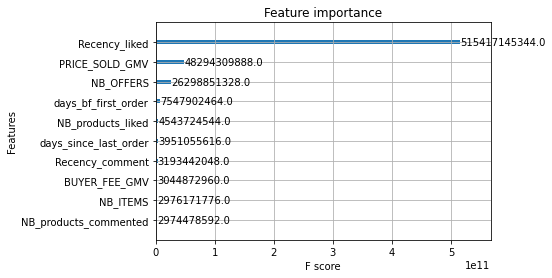

---------


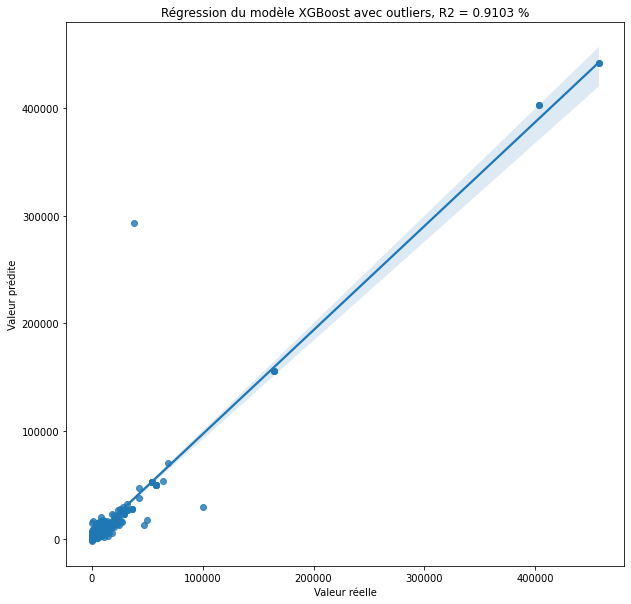

-------
Fin de l'évaluation du modèle XGBoost !


In [23]:
y_pred_xgb, model_test_xgb = xgb_evaluation(df, outliers=True)

In [25]:
# hyperparamter tuning for LightGBM

from skopt import BayesSearchCV
from skopt.space import Real, Integer

def hyperparameter_tuning_lgbm(X_train, X_test, y_train, y_test):
    '''
    Function that performs hyperparameter tuning on LightGBM model

    Parameters
    ----------
    X_train : pandas dataframe
        The train set

    X_test : pandas dataframe
        The test set

    y_train : pandas dataframe
        The train set

    y_test : pandas dataframe
        The test set

    Returns
    -------
    best_model : LightGBM model
        The best model after hyperparameter tuning

    '''

    #set a seed for reproducibility
    np.random.seed(42)

    # Create the parameter grid
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 1000),
        'num_leaves': Integer(10, 100),
        'max_depth': Integer(3, 10),
        'min_child_samples': Integer(10, 100),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(0.0, 0.5),
        'reg_lambda': Real(0.0, 0.5)
    }
        
    # Create the model to use for hyperparameter tuning
    model = LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=42)

    start= time.time()
    # Setup RandomizedSearchCV
    bayes_cv_tuner = BayesSearchCV(
        model,
        param_space,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=0,
        random_state=42,
        scoring='neg_mean_squared_error'
    )

    
    # Fit the RandomizedSearchCV version of model

    bayes_cv_tuner.fit(X_train, y_train)

    # Find the best model hyperparameters
    bayes_cv_tuner.best_params_

    end = time.time()

    print(f'Bayesian Search took {end - start} seconds')

    #print best score and params

    print('Best score: ', bayes_cv_tuner.best_score_)
    print('Best params: ', bayes_cv_tuner.best_params_)

    # Evaluate the RandomizedSearchCV model

    y_pred = bayes_cv_tuner.predict(X_test)

    # Evaluate the model

    print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
    print(f'RMSE score: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
    print(f'R2 score: {r2_score(y_test, y_pred)}')


    # Create a dataframe with the feature importance

    feature_importance = pd.DataFrame({'Feature': colnames, 'Importance': bayes_cv_tuner.best_estimator_.feature_importances_})

    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Plot the feature importance

    plt.figure(figsize=(10, 10))

    sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])

    plt.title('Feature Importance')

    plt.show()


    # plot residual plot pour le modèle LightGBM

    plt.figure(figsize=(10, 10))
    sns.regplot(x=y_test, y=y_pred)
    plt.xlabel('Valeur réelle')
    plt.ylabel('Valeur prédite')
    plt.title(f'Régression du modèle LightGBM, R2 = {np.round(r2_score(y_test, y_pred),4)} %')
    plt.show()

    return bayes_cv_tuner.best_estimator_


Bayesian Search took 295.5731620788574 seconds
Best score:  -8490617.04185921
Best params:  OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.15155247944691969), ('max_depth', 10), ('min_child_samples', 10), ('n_estimators', 1000), ('num_leaves', 10), ('reg_alpha', 0.5), ('reg_lambda', 0.0), ('subsample', 0.9121342258738361)])
MSE score: 14134913.21919379
RMSE score: 3759.642698341664
MAE score: 697.8588014958486
R2 score: 0.9686385879542103


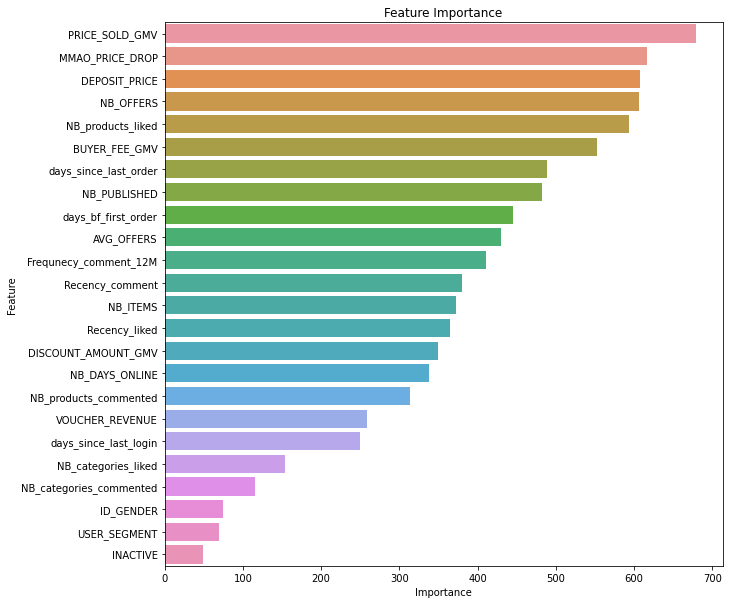

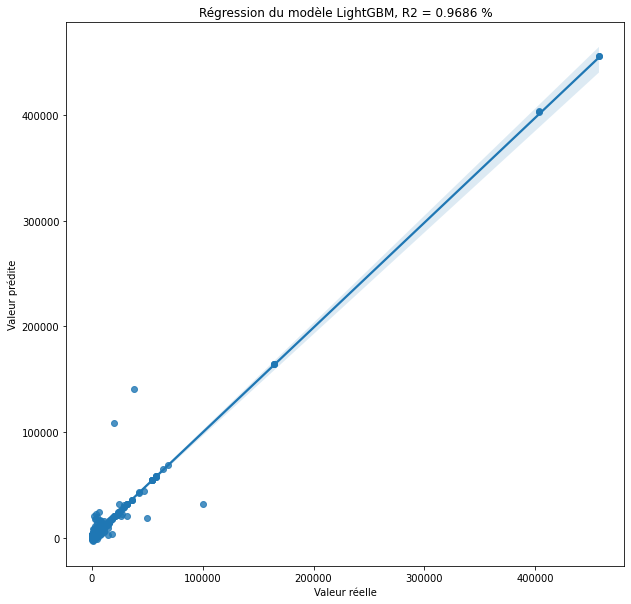

In [26]:
best_model_lgbm = hyperparameter_tuning_lgbm(X_train, X_test, y_train, y_test)

In [ ]:
df.CLTV.describe()